
# TensorFlow Object Detection

https://github.com/tensorflow/models/tree/master/research/object_detection

In [1]:
# нужно понижение версии numpy
!pip install -U numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.8 MB 34.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# решает проблему при обучении ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject
!pip uninstall pycocotools
!pip install pycocotools --no-binary :all: --no-build-isolation

Found existing installation: pycocotools 2.0.4
Uninstalling pycocotools-2.0.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pycocotools-2.0.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pycocotools/*
Proceed (y/n)? y
  Successfully uninstalled pycocotools-2.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 33.5 MB/s 
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=265173 sha256=593d3ea82cd7402bcda75641333c8731c3ca027ba88ae37079b14661692d2fcc
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [3]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
tf.enable_eager_execution()

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
1.15.2


### Рабочая директория
Все данные будем хранить в директории `/content/tf_od_demo` (TensorFlow Object Detection Demo)

При первом запуске создадим директорию (если её еще не существует), в противном случае надо заменить True на False.

При последующих подключениях к диску (в том числе в других ноутбуках) директорию создавать не надо, в ней уже будут сохранены все данные, которые мы туда поместили.

In [4]:
!mkdir "/content/tf_od_demo"
%cd "/content/tf_od_demo"

/content/tf_od_demo


### Подготовка библиотеки `object_detection`
Библиотека `object_detection` находится в репозитории `tensorflow/models` в разделе `research`

Необходимо склонировать код библиотеки и сконфигурировать модели (сбилдить прото модели).

Этот шаг нужно сделать один раз (не повторять, если папка `models` уже находится в текущей директории).

Подробнее: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

In [5]:
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 75394, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 75394 (delta 121), reused 192 (delta 98), pack-reused 75161
Receiving objects: 100% (75394/75394), 580.68 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (53488/53488), done.


### Загрузка библиотек
Загрузка библиотек. Кроме того, загрузка модуля `dataset_util` из пакета `object_detection`, который будет нужен для создания датасета в нужном формате.

In [6]:
import pandas as pd
import os
from PIL import Image

import sys
sys.path.insert(0, 'models/research')

from object_detection.utils import dataset_util

In [8]:
%cd /content/tf_od_demo/models/research

/content/tf_od_demo/models/research


In [9]:
# настройка модулей для object_detection
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf1/setup.py .
!python3 -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/tf_od_demo/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 352 kB 33.1 MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1694773 sha256=7467fd77521f028121b66598dd9f842f4ce22c01040ab18f622b81c89696c182
  Stored in directory: /tmp/pip-ephem-wheel-cache-ul_0cg2c/wheels/c6/1b/0f/63799c0d30b84ae2a2cb6776ff75429a3707696c15e65c979d
Successfully built object-detection


In [10]:
# проверка работоспособности модели
%cd "/content/tf_od_demo"
!cd models/research && protoc object_detection/protos/*.proto --python_out=.
!cd models/research && export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim && python object_detection/builders/model_builder_test.py

/content/tf_od_demo
Using TensorFlow backend.


### Функция для создания одного обучающего образца
В этой функции создаётся экземпляр класса `tf.train.Example`, который соответствует одной обучающей картике. Ей могут соответствовать несколько ground-truth баундинг боксов. Однако, конкретно в данном примере на картинке есть строго один бокс. В противном случае списки `xmins`, `xmaxs`, `ymins`, `ymaxs`, `classes_text`, `classes` должны иметь соответствующее количество элементов ( = кол-ву боксов на данной картинке).

Создавать экземпляры класса `tf.train.Example` можно произвольным способом. В данном примере на вход в функцию подаётся строка из CSV файла (`annot.csv`). Главное -- заполнить соовтестсвующие поля словаре `feature={...}`

Подробнее: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md

In [11]:
def create_tf_example(example):
  
    img_fpath = os.path.join('my_data', example.id)
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(example.id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [example.xmin / float(width)] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [example.xmax / float(width)] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [example.ymin / float(height)] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [example.ymax / float(height)] 
    # List of string class name of bounding box (1 per box)
    classes_text = [str.encode(example.classes_text)] # b'example.classes_text'
    # List of integer class id of bounding box (1 per box)
    classes = [example.classes] #classes from annot

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

### Чтение CSV файла с разметкой
В данном файле представлена разметка обучающих изображений. Сам файл и его формат показаны лишь для примера, они никак не связаны с библиотекой `object_detection`. Наша финальная цель -- создать датасет в формате `TFRecord`, состоящий из экземпляров `tf.train.Example`.

In [12]:
%cd "/content/tf_od_demo"
# загрузка файла с локального диска
from google.colab import files
uploaded = files.upload()
if True:
  !7z x my_data_car_cat.7z

/content/tf_od_demo


Saving my_data_car_cat.7z to my_data_car_cat.7z

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 469389 bytes (459 KiB)

Extracting archive: my_data_car_cat.7z
--
Path = my_data_car_cat.7z
Type = 7z
Physical Size = 469389
Headers Size = 409
Method = LZMA2:19
Solid = +
Blocks = 1

  0%    Everything is Ok

Folders: 1
Files: 12
Size:       476447
Compressed: 469389


In [13]:
annot = pd.read_csv('my_data/annot.csv')
annot.head()

,id,xmin,ymin,xmax,ymax,classes_text,classes
0,1.JPEG,116,578,364,833,Car,1
1,1.JPEG,111,340,282,471,Toy_Cat,2
2,2.JPEG,155,570,466,693,Car,1
3,2.JPEG,140,263,310,397,Toy_Cat,2
4,3.JPEG,118,515,370,769,Car,1


### Создание TFRecord
Здесь мы создаём финальный датасет в формате `TFRecord`, который необходим для запуска обучения TF Object Detection. 

В цикле по всем обучающим образцам создаем `TF Example` и записываем его в `TF Record`.

In [14]:
writer = tf.python_io.TFRecordWriter('my_data/train_data.record') #tf.python_io.TFRecordWriter версия 1, версия 2 tf.compat.v1.python_io.TFRecordWriter

for idx, row in annot.iterrows():
    tf_example = create_tf_example(row)
    writer.write(tf_example.SerializeToString())

writer.close()

### Загрузка предобученной модели
Во время обучения мы будем делать fine-tuning предобученной модели. Для этого необходимо загрузить веса соответствующей модели `ssd_mobilenet_v1_coco`. Из названия следует, что детекционная архитектура -- `SSD`, базовая CNN модель -- `MobileNet_v1`, предобучена на датасете COCO.

Этот шаг нужно сделать один раз (не повторять, если модель уже была скачана ранее).

In [15]:
if True:
    !wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
    !tar -xzf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2022-07-19 04:54:28--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.10.128, 2404:6800:4003:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.10.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  73.00M  55.7MB/s    in 1.3s    

2022-07-19 04:54:30 (55.7 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’ saved [76541073/76541073]



### Подготовка данных для обучения
Ранее мы подготовили файл `train_data.record`, в котором содержится обучающий датасет.
Кроме него для обучения необходимо подготовить еще два файла (они также находятся в папке `my_data`)

* `label_map.pbtxt` (в нашем случае `cube_label_map.pbtxt`) - файл с описанием классов. В нашем случае у нас всего один класс.

* `pipeline.config` - файл, содержищий различне гиперпарамтеры и настройки обучения. Важные параметры: `num_classes`, `fine_tune_checkpoint`, `label_map_path`, `input_path`. В данном примере и для обучения и для теста используется один и тот же датасет (см. блоки параметров `train_input_reader`, `eval_input_reader`)

### Запуск обучения
После того, как мы подготовили все данные, запустить обучение очень просто: надо просто запустить скрипт `model_main.py` и передать ему соответствующие параметры.

*   Путь к файлу `pipeline.config`
*   Директорию, для записи выхода обучения (`model_dir`)
*   Количество итераций обучения (`num_train_steps`)



In [16]:
%%time

if False:
    # Delete output directory
    !rm -rf my_data/output

!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/model_main.py \
    --pipeline_config_path=my_data/pipeline.config \
    --model_dir=my_data/output \
    --num_train_steps=20000 \
    --alsologtostderr

Using TensorFlow backend.
W0719 04:54:44.419021 139866687502208 model_lib.py:839] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0719 04:54:44.419254 139866687502208 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0719 04:54:44.419349 139866687502208 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0719 04:54:44.419430 139866687502208 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0719 04:54:44.419525 139866687502208 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0719 04:54:44.419643 139866687502208 model_lib.py:855] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs

### Заморозка модели
Для того, чтобы использовать обученную модель в режиме инференса, её нужно "заморозить". Другими словами - подготовить к инференсу. Для этого надо запустить скрипт `export_inference_graph.py` и передать соответствующие парамтеры.

* Путь к файлу `pipeline.config`
* Путь к весам обученной модели (`trained_checkpoint_prefix`)
* Путь к директории для сохранения замороженной модели (`output_directory`)

In [17]:
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=my_data/pipeline.config \
    --trained_checkpoint_prefix=my_data/output/model.ckpt-20000 \
    --output_directory=my_data/output/frozen/

Using TensorFlow backend.
Instructions for updating:
Please use `layer.__call__` method instead.
W0719 05:27:03.405789 140380346206080 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0719 05:27:04.689746 140380346206080 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0719 05:27:04.724104 140380346206080 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0719 05:27:04.756901 140380346206080 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:dep

### Загрузка библиотек
Загрузка библиотек. Кроме того, загрузка различных модулей из пакета `object_detection`.

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import imageio

import sys
sys.path.insert(0, 'models/research')

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Загрузка соответствия имён классов и их ID

In [19]:
PATH_TO_LABELS = 'my_data/car_cat_label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Загрузка замороженного графа для инференса

In [20]:
PATH_TO_FROZEN_GRAPH = 'my_data/output/frozen/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef() #tf.compat.v1.GraphDef()   # -> instead of tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid: #tf.compat.v2.io.gfile.GFile()   # -> instead of tf.gfile.GFile()
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Функция для детектирования объектов на одном изображении

In [21]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[ 'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

### Запуск детектрования объектов

In [22]:
image_np = imageio.imread('my_data/test.JPEG')
image_np_expanded = np.expand_dims(image_np, axis=0)

output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

### Визуализация результатов детектирования
Визуализируем получившиеся детекции. Здесь их можно дополнительно отфильтровать по скору, используя `min_score_thresh`

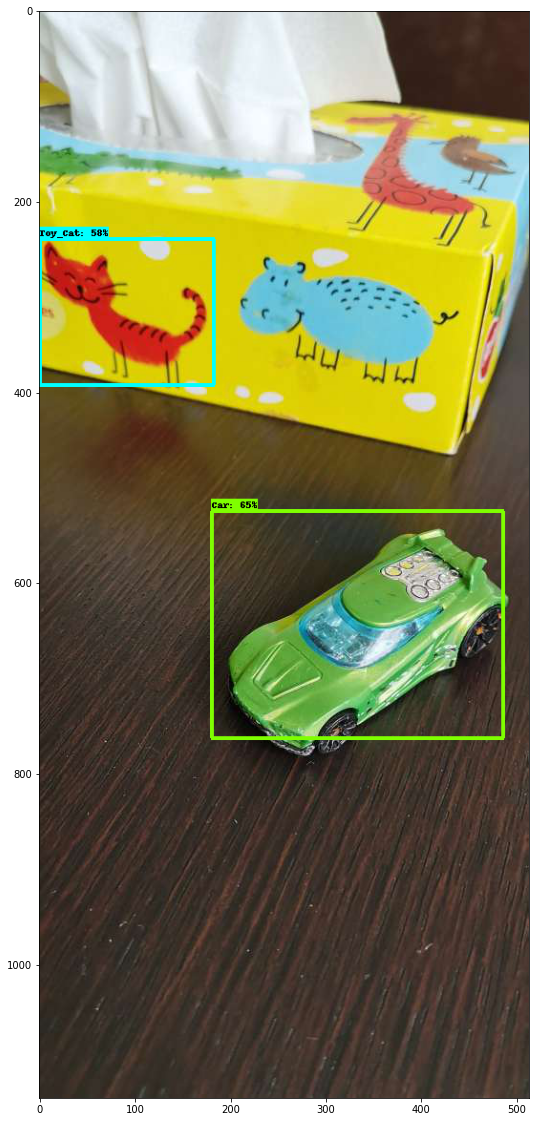

In [24]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=4,
    min_score_thresh=0.5)

%matplotlib inline
plt.figure(figsize=(20,20))
plt.imshow(image_np)